In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.autograd.functional as dp
from torch.autograd import grad
from numpy import pi

import datetime as DT
import copy

In [62]:
# Se implementan instancias particulares de funciones de pytorch para simplificar el trabajo más adelante. Se implementan otras funciones útiles

# Crear una función para modificar las funciones para graficar

def tensor(x,requires_grad=True) -> torch.Tensor:
    """ Genera un tensor de numpy para usarlo en una PINN. Tiene la opción de gradiente activa por defecto.
        
        Keyword arguments:
        x -- valor o conjunto de valores para convertir en tensor
        requires_grad -- valor que indica si requiere calcularse el gradiente del vector. Por defecto True.
        
        Returns
        Tensor de pytorch con los valores de x
    """
    if not 'device' in globals(): device='cpu'
    return torch.tensor(x,requires_grad=requires_grad).to(device)

def detach(x:torch.Tensor) -> np.ndarray :
    """ Genera el detach de un tensor de pytorch para poder graficarlo con matplotlib
        
        Keyword arguments:
        x -- tensor al cual realizarle detach
        
        Returns
        Un vector de numpy equivalente
    """
    return x.detach().numpy()

def linspace(inf_lim,sup_lim,N=100,reshape=True,requires_grad=True):
    """ Genera un linspace de pytorch entre inf_lim y sup_lim con N puntos. Por defecto se realiza un redimensionamiento para obtener una matriz de una columna.
        
        Keyword arguments:
        inf_lim -- límite inferior del linspace
        sup_lim -- límte superior del linspace
        N -- número de puntos. Por defecto 100
        reshape -- True para realizar el redimensionamiento, False para omitirlo. Por defecto True
    """
    if not 'device' in globals(): device='cpu'
    return torch.linspace(inf_lim,sup_lim,N,requires_grad=requires_grad).reshape(N,1).to(device) if reshape else torch.linspace(inf_lim,sup_lim,N,requires_grad=requires_grad).to(device)

In [63]:
def plot2D(f,rango:tuple = ((0,1),(0,1)), N_x:int = 100, N_y:int = None, N_salidas:int = 1, figsize:tuple = (7,14), plot_cut:tuple = None, axes:tuple = None) -> None: # Genera una gráfica 2D de la función f
    # plot_cut = tuple['axis',cuts]: 'axis' = 'x' or 'y', cut:list[float]
    """ Genera un gráfico 2D (como mapa de calor) de una función con entradas de dos coordenadas, sea un campo escalar f: R2 --> R, ó un campo vectorial f: R2 --> R2. Para campos escalares se grafica la
        salida como intensidad en un mapa de calor. Para funciones vectoriales se grafica la norma como un mapa de calor y las direcciones con flechas. Permite realizar 'cortes' 1D a lo largo del espacio
        bidimensional, es decir, tomar una curva unidimensional en el espacio 2D y realizar la gráfica de la función a lo largo de dicha curva. La curva se puede definir como una función de python que
        represente y(x) ó x(y). También se reciben floats para cortes verticales/horizonales. Hay soporte para múltiples cortes siempre que todos se definan para una sóla coordenada, x ó y. Las funciones
        deben estar definidas para ser compatibles con tensores de pytorch.
        
        Keyword arguments:
        f -- la función que se graficará. type(f) = function
        rango -- el espacio en R2 en el que se graficará la función, dado como una tupla ((límite_inferior_x,límite_superior_x),(límite_inferior_x,límite_superior_x))
        N_x -- resolución en x de la gráfica resultante
        N_y -- resolución en y de la gráfica resultante. Pasar None indica que se utilice la misma resolución de x 
        N_salida -- un entero 1 ó 2, que representa el número de salidas de la función
        figsize -- tamaño de la figura
        plot_cut -- tupla que contiene: un string que indica cuál variable representa la función deseada, y una tupla de funciones/floats. e.g. ('y',(torch.sqrt,3.3,torch.abs)). None si no se desea hacer
            cortes
        axes -- tupla de instancias de matplotlib.Axes.axes sobre las cuales se desee realizar las gráficas. None si se desea crear una nueva figura.
        
        Returns:
        None
    """
    
    (inf_x,sup_x),(inf_y,sup_y) = rango
    if not N_y: N_y = N_x
    if not 'device' in globals(): device='cpu' # Pone los tensores en el dispositivo escogido
    
    # Genera los axes
    if axes is None:
        fig = plt.figure(figsize=figsize)
        if plot_cut is not None:
            gs = fig.add_gridspec(2, hspace=0)
            heatmap,cutplot = gs.subplots(sharex=True, sharey=False)
        else:
            fig,heatmap = plt.subplots()
    else:
        if plot_cut is not None:
            heatmap,cutplot = axes
        else:
            heatmap = axes[0]
    
   
    # Se genera el sampleo de x,y. Se genera una matriz donde se van a almacenar los valores del mapa de calor 
    x,y = torch.linspace(inf_x,sup_x,N_x).to(device),torch.linspace(inf_y,sup_y,N_y).to(device)
    resultado = np.zeros((len(x),len(y)))
    
    # Se llena la matriz
    if N_salidas==1: # Si la función es un campo escalar (N_salidas=1) se llena la matriz con las salidas de la función
        for i in range(len(y)):
            for j in range(len(x)):
                z = f(torch.tensor([x[j],y[i]]).to(device))
                resultado[i,j] = z
    
    elif N_salidas==2:  # Si la función es un campo vectorial (N_salidas=2) se llena la matriz con las salidas de la función
        res_x = (rango[0][1] - rango[0][0])/N_x
        res_y = (rango[1][1] - rango[1][0])/N_y
        for i in range(len(y)):
            for j in range(len(x)):
                z = f(torch.tensor([x[j],y[i]]).to(device)) # Guardar z en una lista y usarla para generar el diagrama de flechas
                norm = torch.sqrt(torch.sum(torch.pow(z[:2],2))) ### Cambié para que sólo sea velocidad
                resultado[i,j] = norm
                
                if i%int(N_x/10 - 1)==0 and j%int(N_y/10 - 1)==0:
                    L0 = detach(norm)
#                     x_length = max(min(detach(z[0]),1.,key=abs),0.2,key=abs)/detach(norm)*res_x*5 #*res_x*5
#                     y_length = max(min(detach(z[1]),1.,key=abs),0.2,key=abs)/detach(norm)*res_y*5
#                     x_length = detach(z[0])/detach(norm)*res_x*5
#                     y_length = detach(z[1])/detach(norm)*res_y*5
                    x_length = detach(z[0])*(1.2*np.tanh(0.5*L0)+0.3)/L0*res_x*5
                    y_length = detach(z[1])*(1.2*np.tanh(0.5*L0)+0.3)/L0*res_y*5
                    head_width = 0.015*(np.mean([sup_x-inf_x,sup_y-inf_y]))
                    heatmap.arrow(detach(x[j]),detach(y[i]),x_length,y_length,head_width=head_width,facecolor='black')
                
     # Genera el mapa de calor
    heatmap.imshow(resultado,origin='lower',extent=[inf_x,sup_x,inf_y,sup_y])
    heatmap.set_xlim(inf_x,sup_x)
    heatmap.set_ylim(inf_y,sup_y)
    heatmap.label_outer()
    
    # Genera el gráfico de cortes, y coloca las curvas en el mapa de calor
    if plot_cut is not None:
        for cut in plot_cut[1]:
            N = N_x if plot_cut[0] == 'y' else N_y
            abscissa = torch.linspace(inf_x,sup_x,N).reshape(N,1)
            if type(cut) == float:
                ordinate = cut*torch.ones(N).reshape(N,1)
                label = plot_cut[0]+' = {:.1f}'.format(cut)
            elif callable(cut):
                ordinate = cut(abscissa)
                label = plot_cut[0]+' = '+cut.__name__+ ( '(x)' if plot_cut[0] == 'y' else '(y)')
            x,y = (abscissa,ordinate) if plot_cut[0] == 'y' else (ordinate,abscissa) 
            xy = torch.hstack((x,y))
            z = f(xy) if N_salidas == 1 else torch.sqrt(torch.sum( torch.pow(f(xy),2), axis=1 ))
            cutplot.plot(detach(x),detach(z),label=label)
            heatmap.plot(x,y,color='red')
        cutplot.label_outer()
        cutplot.yaxis.get_major_ticks()[-1].label1.set_visible(False)
        cutplot.legend()
        heatmap.yaxis.get_major_ticks()[0].label1.set_visible(False)
        
    heatmap.set_aspect('auto')
    

def plot2D_error(f,rango:tuple = ((0,1),(0,1)), N_x:int = 100, N_y:int = None, figsize:tuple = (7,14), plot_cut:tuple = None, axes:tuple = None) -> None: # Genera una gráfica 2D del error de la función f
    # plot_cut = tuple['axis',cuts]: 'axis' = 'x' or 'y', cut:list[float]
    """ Genera un gráfico 2D (como mapa de calor) del error de una función con entradas de dos coordenadas, sea un campo escalar f: R2 --> R, ó un campo vectorial f: R2 --> R2. Permite realizar 'cortes'
        1D a lo largo del espacio bidimensional, es decir, tomar una curva unidimensional en el espacio 2D y realizar la gráfica de la función a lo largo de dicha curva. La curva se puede definir como
        una función de python que represente y(x) ó x(y). También se reciben floats para cortes verticales/horizonales. Hay soporte para múltiples cortes siempre que todos se definan para una sola
        coordenada, x ó y. Las funciones deben estar definidas para ser compatibles con tensores de pytorch.
        
        Keyword arguments:
        f -- la función cuyo error se graficará. type(f) = function
        rango -- el espacio en R2 en el que se graficará la función, dado como una tupla ((límite_inferior_x,límite_superior_x),(límite_inferior_x,límite_superior_x))
        N_x -- resolución en x de la gráfica resultante
        N_y -- resolución en y de la gráfica resultante. Pasar None indica que se utilice la misma resolución de x
        figsize -- tamaño de la figura
        plot_cut -- tupla que contiene: un string que indica cuál variable representa la función deseada, y una tupla de funciones/floats. e.g. ('y',(torch.sqrt,3.3,torch.abs)). None si no se desea hacer
            cortes
        axes -- tupla de instancias de matplotlib.Axes.axes sobre las cuales se desee realizar las gráficas. None si se desea crear una nueva figura.
        
        Returns:
        None
    """
    
    (inf_x,sup_x),(inf_y,sup_y) = rango
    if not N_y: N_y = N_x
    if not 'device' in globals(): device='cpu' # Pone los tensores en el dispositivo escogido
    
    # Genera los axes
    if axes is None:
        fig = plt.figure(figsize=figsize)
        if plot_cut is not None:
            gs = fig.add_gridspec(2, hspace=0)
            heatmap,cutplot = gs.subplots(sharex=True, sharey=False)
        else:
            fig,heatmap = plt.subplots()
    else:
        if plot_cut is not None:
            heatmap,cutplot = axes
        else:
            heatmap = axes[0]
    
   
    # Se genera el sampleo de x,y. Se genera una matriz donde se van a almacenar los valores del mapa de calor 
    x,y = torch.linspace(inf_x,sup_x,N_x).to(device),torch.linspace(inf_y,sup_y,N_y).to(device)
    resultado = np.zeros((len(x),len(y)))
    
    # Se llena la matriz
    for i in range(len(y)):
        for j in range(len(x)):
            z = error(tensor([x[j],y[i]]).reshape(1,2).to(device))
            resultado[i,j] = z

     # Genera el mapa de calor
    im = heatmap.imshow(resultado,origin='lower',extent=[inf_x,sup_x,inf_y,sup_y])
    heatmap.figure.colorbar(im)
    heatmap.set_xlim(inf_x,sup_x)
    heatmap.set_ylim(inf_y,sup_y)
    heatmap.label_outer()
    
    # Genera el gráfico de cortes, y coloca las curvas en el mapa de calor
    if plot_cut is not None:
        for cut in plot_cut[1]:
            N = N_x if plot_cut[0] == 'y' else N_y
            abscissa = torch.linspace(inf_x,sup_x,N).reshape(N,1)
            if type(cut) == float:
                ordinate = cut*torch.ones(N).reshape(N,1)
                label = plot_cut[0]+' = {:.1f}'.format(cut)
            elif callable(cut):
                ordinate = cut(abscissa)
                label = plot_cut[0]+' = '+cut.__name__+ ( '(x)' if plot_cut[0] == 'y' else '(y)')
            x,y = (abscissa,ordinate) if plot_cut[0] == 'y' else (ordinate,abscissa) 
            xy = torch.hstack((x,y))
            z = []
            for xy_i in xy:
                z.append(error(xy))
            cutplot.plot(detach(x),z,label=label)
            heatmap.plot(x,y,color='red')
        cutplot.label_outer()
        cutplot.yaxis.get_major_ticks()[-1].label1.set_visible(False)
        cutplot.legend()
        heatmap.yaxis.get_major_ticks()[0].label1.set_visible(False)
        
    heatmap.set_aspect('auto')

In [4]:
def vel_jacobian(X,f): # Este jacobiano se calcula para una base de entrada de tamaño 2 y una base de salida de tamaño 3, donde sólo se quiere sacar el jacobiano para las dos primeras salidas
    # Transposed!!: esta función retorna el jacobiano en la forma convencional, no en la forma transpuesta que usa torch
     
    basis_out = [torch.tensor([1.,0.,0.]).reshape(1,3) , torch.tensor([0.,1.,0.]).reshape(1,3)]
    
    if len(X.size()) == 1 or X.size()[0]==1:
        o = basis_out[0]
        J = grad(f(X),X,grad_outputs=o,create_graph=True)[0]
        for o in basis_out[1:]:
            g = grad(f(X),X,grad_outputs=o,create_graph=True)[0]
            J = torch.vstack([J,g])
        return J
    elif len(X.size()) == 2:
        x = X[0].reshape(1,2)
        o = basis_out[0]
        J = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
        for o in basis_out[1:]:
            g = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
            J = torch.vstack([J,g])
        Js = J.reshape(1,2,2) # Por qué ese arreglo? I dunno. Así es que lo entiende bien torch
        for x in X[1:]:
            x = x.reshape(1,2)
            o = basis_out[0]
            J = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
            for o in basis_out[1:]:
                g = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
                J = torch.vstack([J,g])
            Js = torch.vstack([Js,J.reshape(1,2,2)])
        return Js

def vel_laplacian(X,f): # Para vectores o vectores de vectores (matrices Nx2)
    
    basis_in = [torch.tensor([1.,0.]).reshape(1,2) , torch.tensor([0.,1.]).reshape(1,2)] # Base de entrada a la función
    basis_out = [torch.tensor([1.,0.,0.]).reshape(1,3) , torch.tensor([0.,1.,0.]).reshape(1,3)] # Base del subespacio del espacio de salida sobre el cual se calcula el laplaciano
    in_out_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]]) # Transformación para que el laplaciano salga con la dimensionalidad del subespacio, no del espacio de salida completo
    
    
    if len(X.size()) == 1 or X.size()[0]==1:
        ΔU = torch.zeros_like(f(X))
        for o1 in basis_out:
            g = grad(f(X),X,grad_outputs=o1,create_graph=True)[0]
            r = torch.zeros_like(g)
            for o2 in basis_in:
                gg = grad(g,X,grad_outputs=o2,create_graph=True)[0]
                r += o2*gg
            ΔU += o1*torch.sum(r)
        ΔU = ΔU@in_out_splicer
        return ΔU
    
    elif len(X.size()) == 2:
        x = X[0].reshape(1,2)
        ΔU = torch.zeros_like(f(x))
        for o1 in basis_out:
            g = grad(f(x),x,grad_outputs=o1,create_graph=True)[0]
            r = torch.zeros_like(g)
            for o2 in basis_in:
                gg = grad(g,x,grad_outputs=o2,create_graph=True)[0]
                r += o2*gg
            ΔU += o1*torch.sum(r)
        ΔU = ΔU@in_out_splicer
        for x in X[1:]:
            x = x.reshape(1,2)
            ΔUi = torch.zeros_like(f(x))
            for o1 in basis_out:
                g = grad(f(x),x,grad_outputs=o1,create_graph=True)[0]
                r = torch.zeros_like(g)
                for o2 in basis_in:
                    gg = grad(g,x,grad_outputs=o2,create_graph=True)[0]
                    r += o2*gg
                ΔUi += o1*torch.sum(r)
            ΔUi = ΔUi@in_out_splicer
            ΔU = torch.vstack([ΔU,ΔUi])
    return ΔU

def pressure_gradient(X,f):
    basis_out = [torch.tensor([0.,0.,1.]).reshape(1,3)] # Base del subespacio  de la salida sobre el que se realiza gradiente
    o = basis_out[0]
    
    if len(X.size()) == 1 or X.size()[0]==1:
        grad_p = grad(f(X),X,grad_outputs=o,create_graph=True)[0]
        return grad_p
    elif len(X.size()) == 2:
        x = X[0].reshape(1,2)
        grad_p = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
        grads_p = grad_p
        for x in X[1:]:
            x = x.reshape(1,2)
            grad_p = grad(f(x),x,grad_outputs=o,create_graph=True)[0]
            grads_p = torch.vstack([grads_p,grad_p])
        return grads_p

torch.Size([500, 2])
torch.Size([500, 2])


tensor(39651.1719, grad_fn=<AddBackward0>)

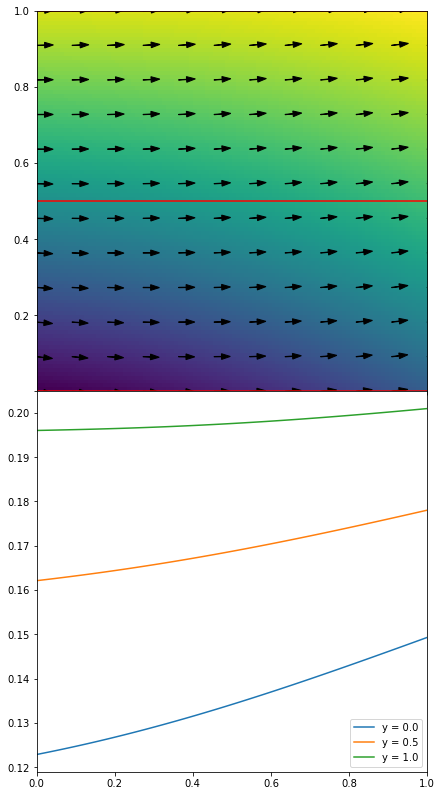

In [6]:
Re = 1
def f(x): # Hay que mirar tiempo
    A = torch.tensor([[1.,1.],[1.,-1.]], requires_grad=True)
    if len(x.size()) == 1:
        return A@x
    elif len(x.size()) == 2: # Sólo funciona para vectores o vectores de vectores (matrices)
        return (A@x.transpose(0,1)).transpose(0,1)


def error(x):
    v_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]])
    U = model(x)@v_splicer
    J = vel_jacobian(x,model)
    L = vel_laplacian(x,model)
    div_v = torch.sum(torch.diagonal(J))
    grad_p = pressure_gradient(x,model)
    
    HN = J@U.T + grad_p - 1/Re*L.T 
    e12 = torch.sum( torch.abs(HN) )
    e3 = torch.abs(div_v)
#     return 0
    return torch.abs( e12 + e3 )

def error_frontera():
    
    N_velocity = 100
    N_pressure = 20
    
    line = linspace(0,1,N=N_velocity)
    zeros = torch.zeros_like(line)
    ones = torch.ones_like(line)
    
    v_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]])
    p_splicer = torch.tensor([0.,0.,1.]).reshape(3,1)
    
    r_bottom,r_left,r_right,r_top = torch.hstack([line,zeros]),torch.hstack([zeros,line]),torch.hstack([ones,line]),torch.hstack([line,ones])
    r_corner = torch.tensor([0.,0.])
    
    e1 = torch.abs( model(r_bottom)@v_splicer - torch.tensor([0.,0.]) )
    e2 = torch.abs( model(r_left)@v_splicer - torch.tensor([0.,0.]) )
    e3 = torch.abs( model(r_right)@v_splicer - torch.tensor([0.,0.]) )
    e4 = torch.abs( model(r_top)@v_splicer - torch.tensor([1.,0.]) )
    e5 = N_pressure*torch.abs( model(r_corner)@p_splicer - torch.tensor(0.) )
    
    return torch.sum(e1+e2+e3+e4) + torch.sum(e5)


alpha = 0.6
def residuales(X):
#     print('Residuales')
    global alpha
    res = 0
    for x in X:
        x = x.reshape(1,2)
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res

N_in = 2
N_out = 3
# model = torch.nn.Sequential(torch.nn.Linear(N_in,8),
#                           torch.nn.Tanh(),
#                           torch.nn.Linear(8,12), 
#                           torch.nn.Tanh(),
#                           torch.nn.Linear(12,12), 
#                           torch.nn.ReLU(),
#                           torch.nn.Linear(12,20), 
#                           torch.nn.ReLU(),
#                           torch.nn.Linear(20,12), 
#                           torch.nn.ReLU(),
#                           torch.nn.Linear(12,8), 
#                           torch.nn.Tanh(),
#                           torch.nn.Linear(8,N_out) )

model = torch.nn.Sequential(torch.nn.Linear(N_in,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,N_out) )

params_iniciales = copy.deepcopy(model.state_dict())

N_dominio = 500
a = 0
b = 1

xy = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True) # N_dominio pares de números aleatorios entre a y b
# x1 = torch.FloatTensor(N_dominio,2).uniform_(N_dominio)
x = xy
z = model(xy)


cortes = (0.,0.5,1.)
plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)

print(xy.size())
print(f(xy).size())
# f(xy)
residuales(x)

Tiempo promedio:	 3.8479080475000003


<Figure size 1728x576 with 0 Axes>

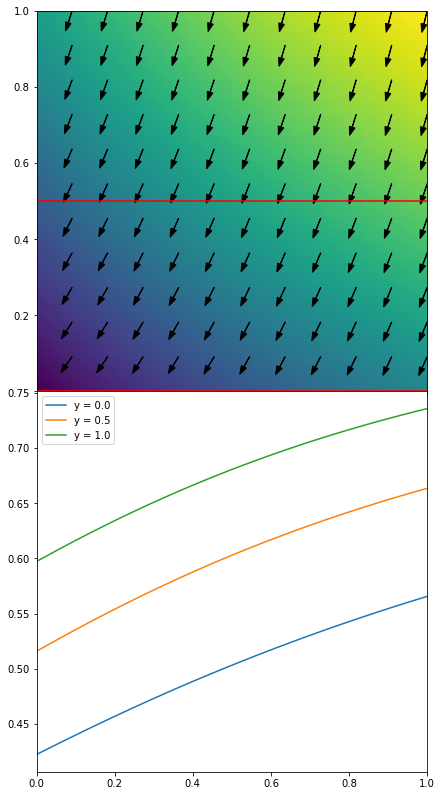

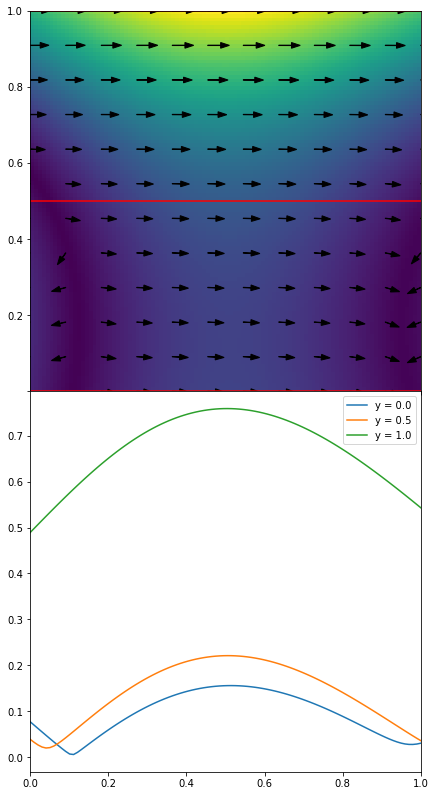

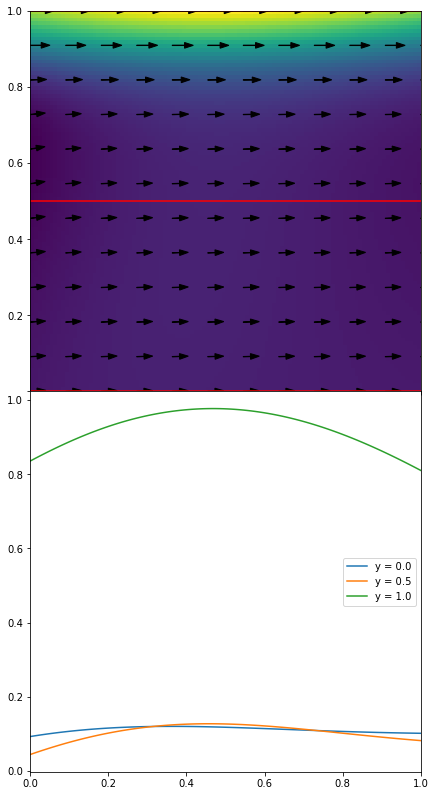

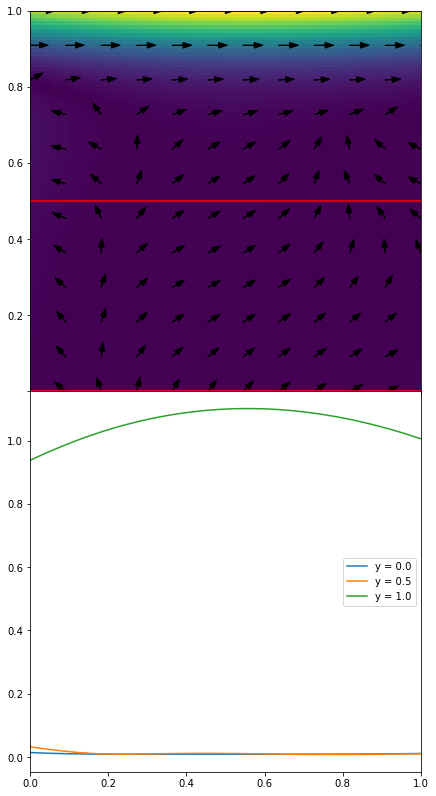

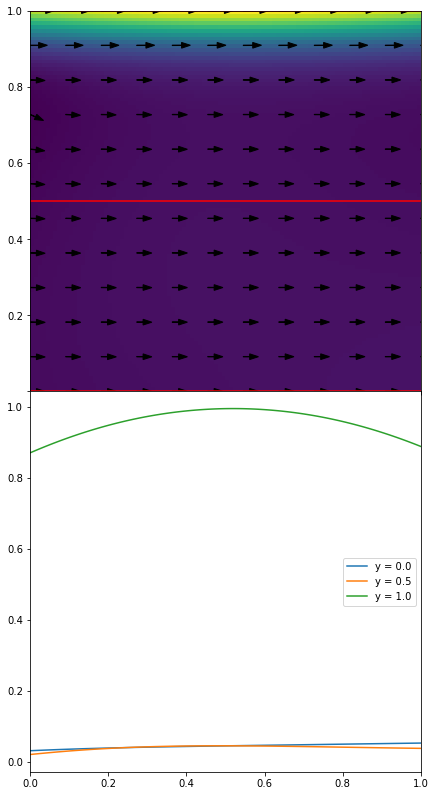

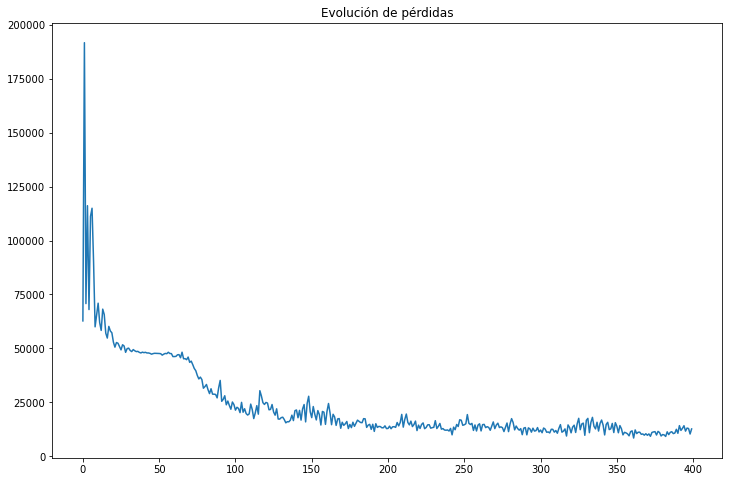

In [15]:
model.load_state_dict(params_iniciales)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)

alpha = 0.95
n_epochs = 400
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    x = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True)
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss.item()) # Cambié loss por loss.item(); el cambio incrementa en 1s el tiempo del ciclo, pero parece solucionar el problema de Ram. Tal vez hay alguna manera de liberar la memoria de loss
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss#.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

In [14]:
x_test = tensor([0.99,0.5])
model(x_test)

tensor([ 1.9696e-04, -9.3728e-05,  5.9538e-03], grad_fn=<AddBackward0>)

Tiempo promedio:	 4.694788985


<Figure size 1728x576 with 0 Axes>

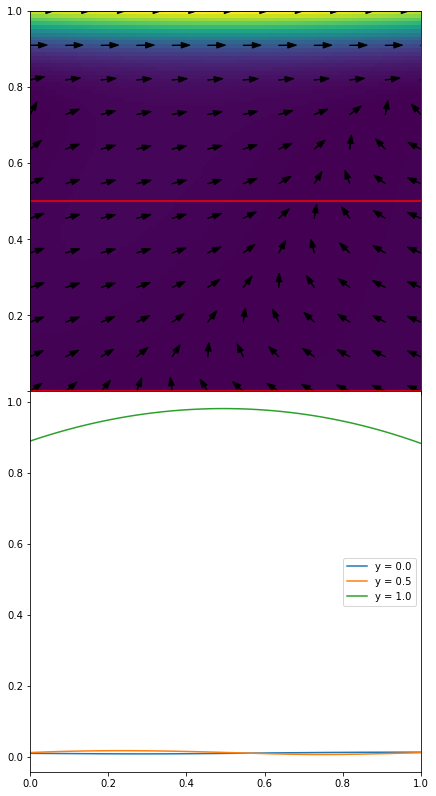

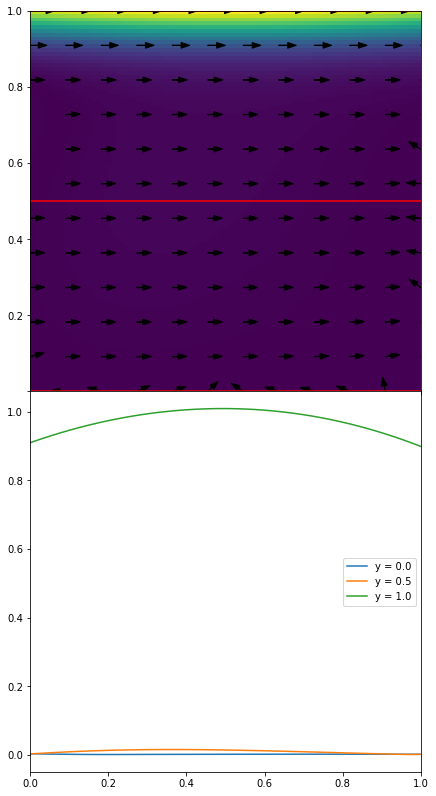

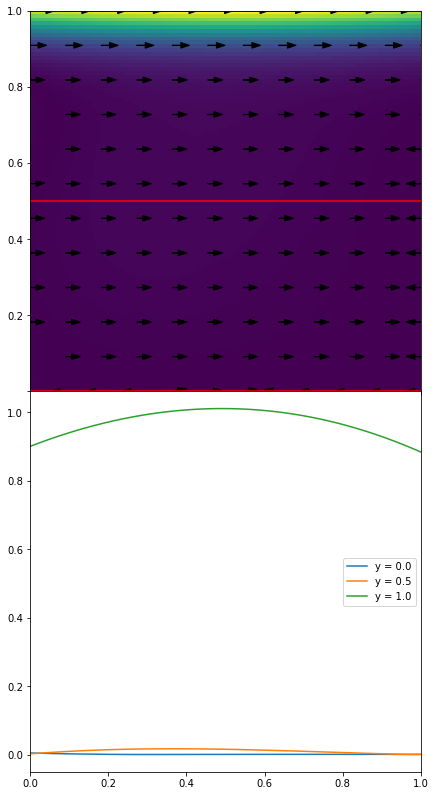

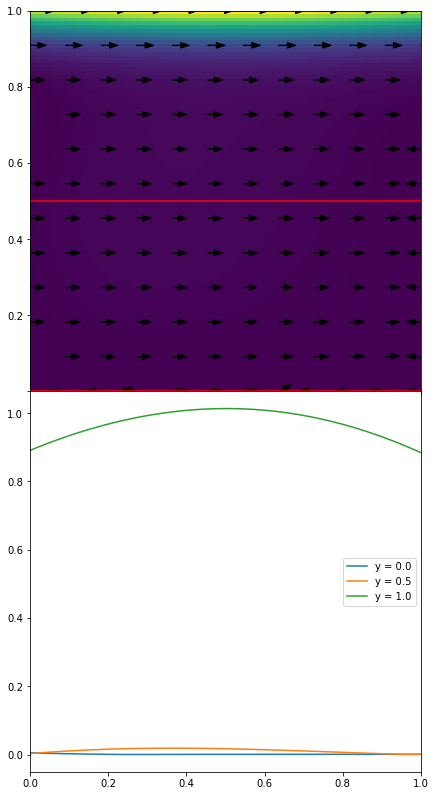

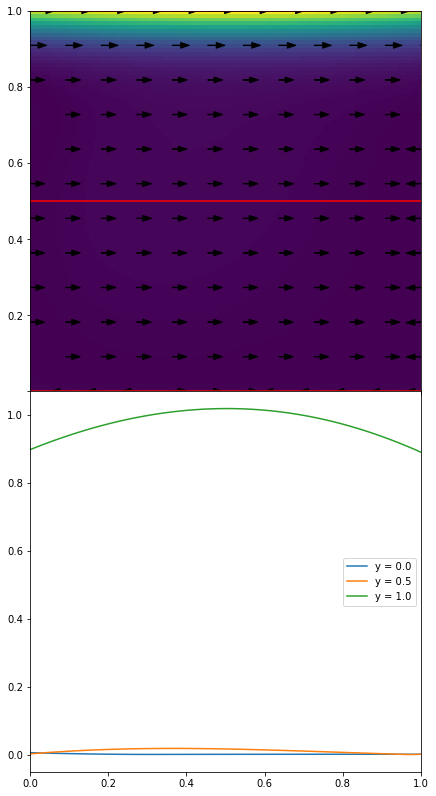

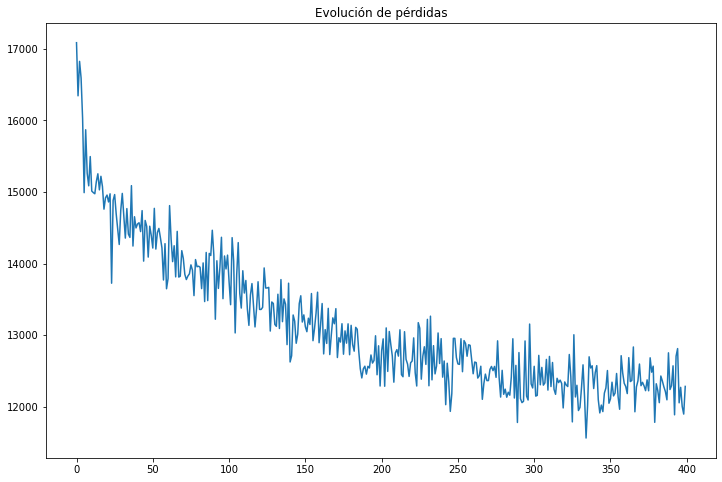

In [22]:
model.load_state_dict(params_finales)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

alpha = 0.8
n_epochs = 400
loss_list = []
t1 = DT.datetime.now()

N_dominio = 400
N_complement = 200

dist = torch.distributions.beta.Beta(5,0.4)

def create_complement_sample(N_complement):
    sample_y = dist.sample((N_complement,))
    sample_y.requires_grad = True
    sample_x = torch.rand(N_complement,requires_grad = True)
    return torch.stack((sample_x,sample_y),dim=1)


plt.figure(figsize=(24,8))
for i in range(n_epochs):
    x1 = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True)
    x2 = create_complement_sample(N_complement)
    x = torch.vstack((x1,x2))
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss.item()) # Cambié loss por loss.item(); el cambio incrementa en 1s el tiempo del ciclo, pero parece solucionar el problema de Ram. Tal vez hay alguna manera de liberar la memoria de loss
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_finales2 = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss#.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

Tiempo promedio:	 3.68363306


<Figure size 1728x576 with 0 Axes>

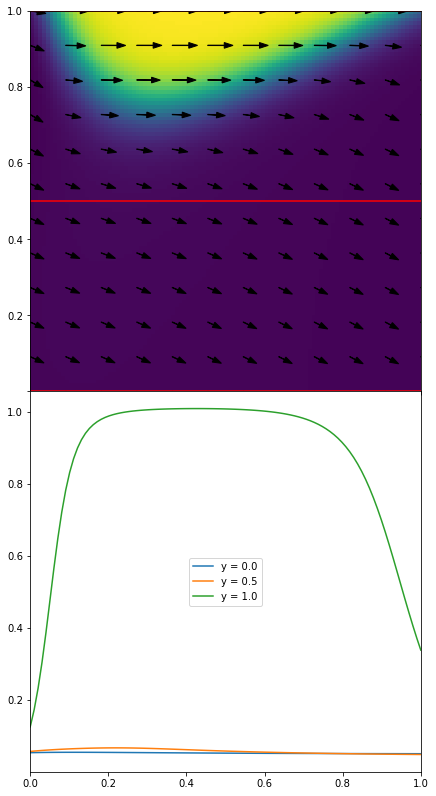

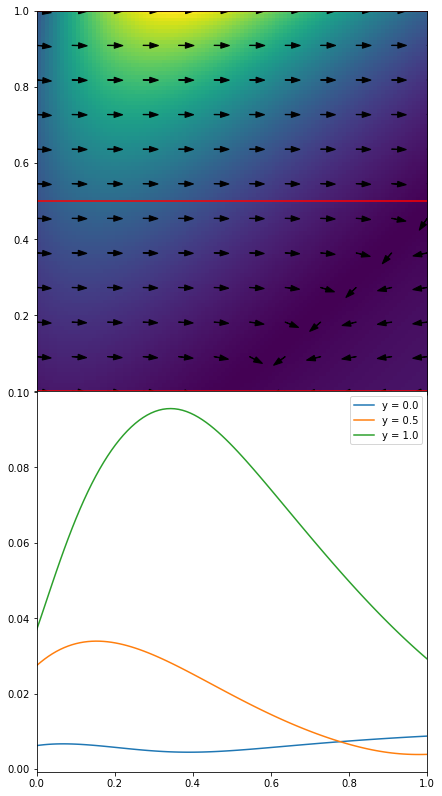

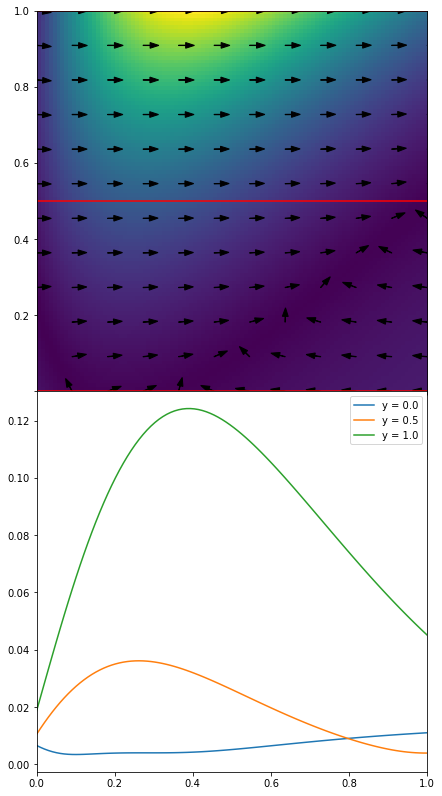

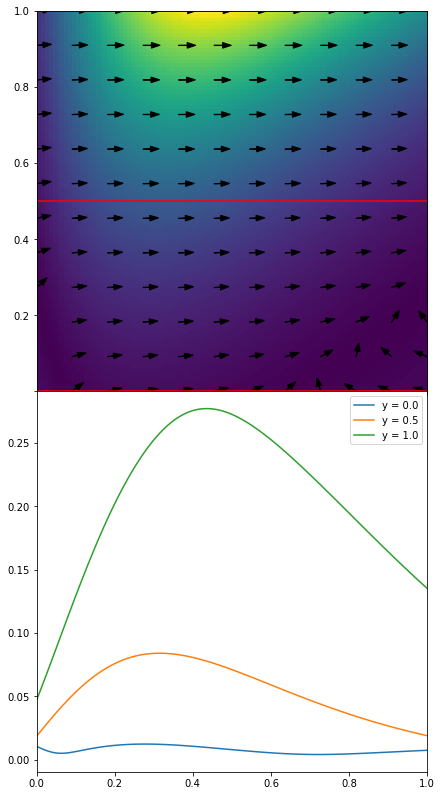

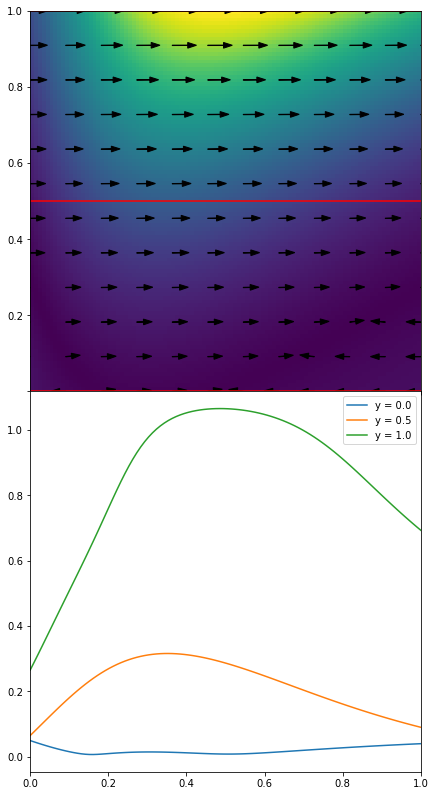

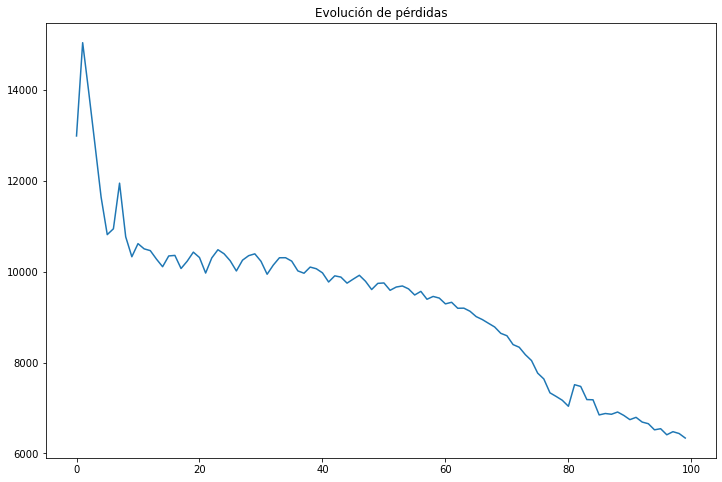

In [14]:
model.load_state_dict(params_finales2)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

alpha = 0.2
n_epochs = 100
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(24,8))
for i in range(n_epochs):
    x = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True)
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss.item()) # Cambié loss por loss.item(); el cambio incrementa en 1s el tiempo del ciclo, pero parece solucionar el problema de Ram. Tal vez hay alguna manera de liberar la memoria de loss
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs

print('Tiempo promedio:\t',avg)

params_finales3 = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss#.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

torch.Size([500, 2])
torch.Size([500, 2])


tensor(64521.5273, grad_fn=<AddBackward0>)

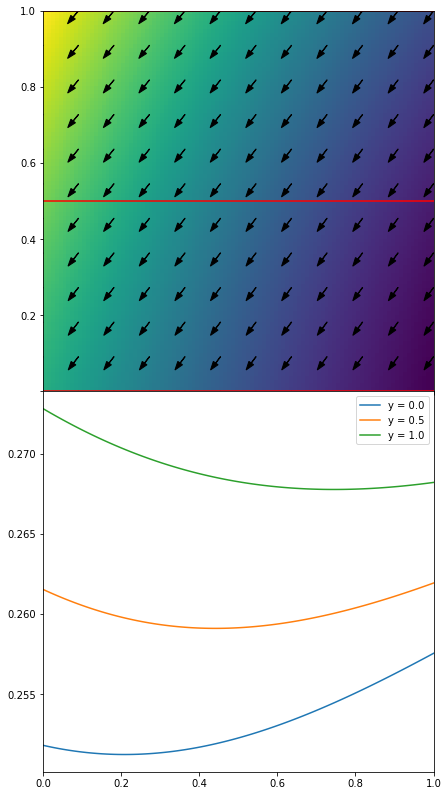

In [5]:
Re = 1
def f(x): # Hay que mirar tiempo
    A = torch.tensor([[1.,1.],[1.,-1.]], requires_grad=True)
    if len(x.size()) == 1:
        return A@x
    elif len(x.size()) == 2: # Sólo funciona para vectores o vectores de vectores (matrices)
        return (A@x.transpose(0,1)).transpose(0,1)


def error(x):
    v_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]])
    U = model(x)@v_splicer
    J = vel_jacobian(x,model)
    L = vel_laplacian(x,model)
    div_v = torch.sum(torch.diagonal(J))
    grad_p = pressure_gradient(x,model)
    
    HN = J@U.T + grad_p - 1/Re*L.T 
    e12 = torch.sum( torch.abs(HN) )
    e3 = torch.abs(div_v)
#     return 0
    return torch.abs( e12 + e3 )

def error_frontera():
    
    N_velocity = 100
    N_pressure = 20
    
    line = linspace(0,1,N=N_velocity)
    zeros = torch.zeros_like(line)
    ones = torch.ones_like(line)
    
    v_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]])
    p_splicer = torch.tensor([0.,0.,1.]).reshape(3,1)
    
    r_bottom,r_left,r_right,r_top = torch.hstack([line,zeros]),torch.hstack([zeros,line]),torch.hstack([ones,line]),torch.hstack([line,ones])
    r_corner = torch.tensor([0.,0.])
    
    e1 = torch.abs( model(r_bottom)@v_splicer - torch.tensor([0.,0.]) )
    e2 = torch.abs( model(r_left)@v_splicer - torch.tensor([0.,0.]) )
    e3 = torch.abs( model(r_right)@v_splicer - torch.tensor([0.,0.]) )
    e4 = torch.abs( model(r_top)@v_splicer - torch.tensor([1.,0.]) )
    e5 = N_pressure*torch.abs( model(r_corner)@p_splicer - torch.tensor(0.) )
    
    return torch.sum(e1+e2+e3+e4) + torch.sum(e5)


alpha = 0.6
def residuales(X):
#     print('Residuales')
    global alpha
    res = 0
    for x in X:
        x = x.reshape(1,2)
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res

N_in = 2
N_out = 3
# model = torch.nn.Sequential(torch.nn.Linear(N_in,8),
#                           torch.nn.Tanh(),
#                           torch.nn.Linear(8,12), 
#                           torch.nn.Tanh(),
#                           torch.nn.Linear(12,12), 
#                           torch.nn.ReLU(),
#                           torch.nn.Linear(12,20), 
#                           torch.nn.ReLU(),
#                           torch.nn.Linear(20,12), 
#                           torch.nn.ReLU(),
#                           torch.nn.Linear(12,8), 
#                           torch.nn.Tanh(),
#                           torch.nn.Linear(8,N_out) )

model = torch.nn.Sequential(torch.nn.Linear(N_in,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,N_out) )

params_iniciales = copy.deepcopy(model.state_dict())

N_dominio = 500
a = 0
b = 1

xy = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True) # N_dominio pares de números aleatorios entre a y b
# x1 = torch.FloatTensor(N_dominio,2).uniform_(N_dominio)
x = xy
z = model(xy)


cortes = (0.,0.5,1.)
plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)

print(xy.size())
print(f(xy).size())
# f(xy)
residuales(x)

Tiempo promedio:	 0.32177081625


<Figure size 1008x576 with 0 Axes>

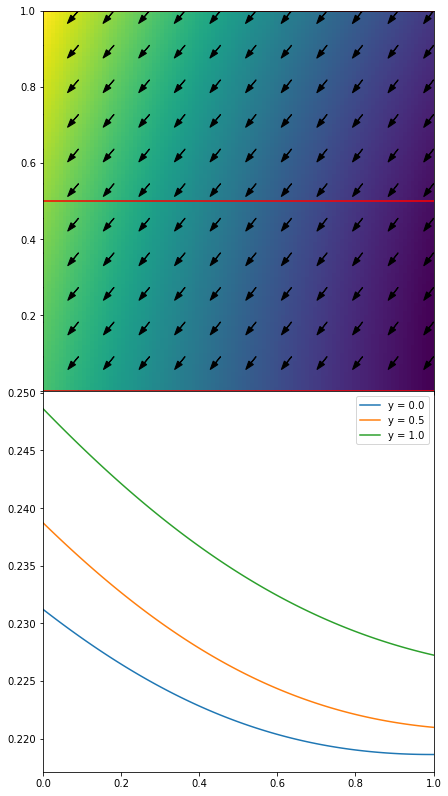

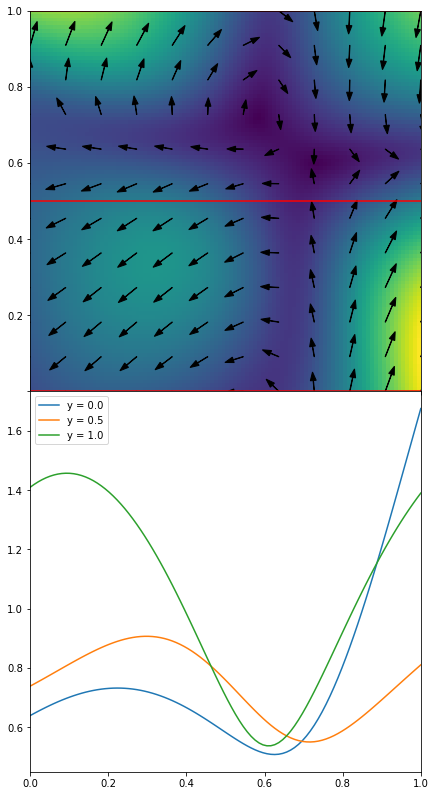

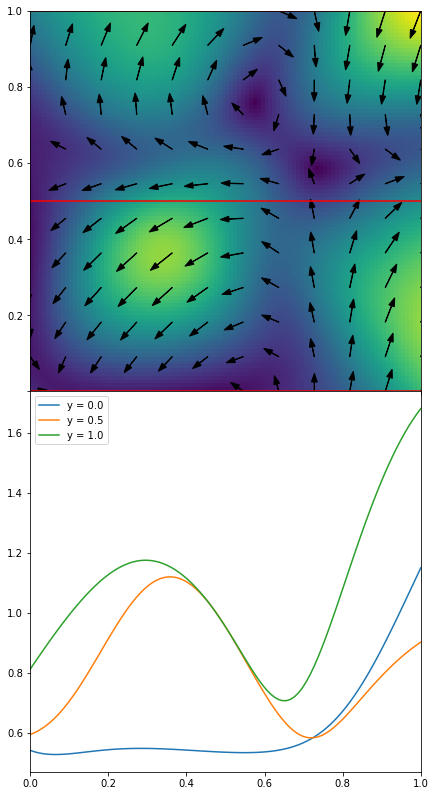

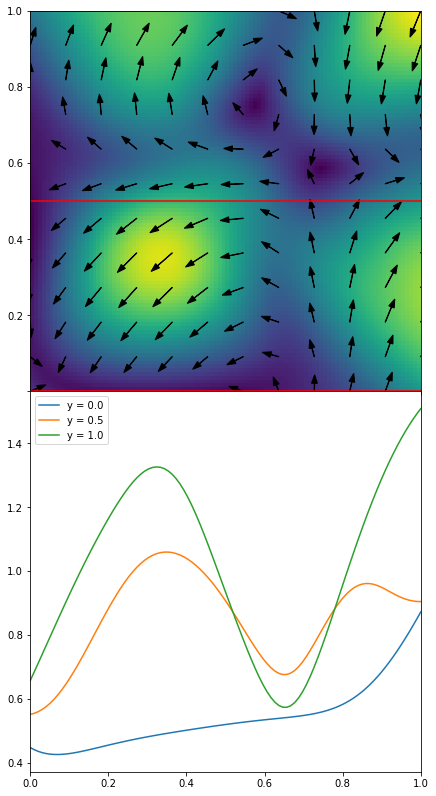

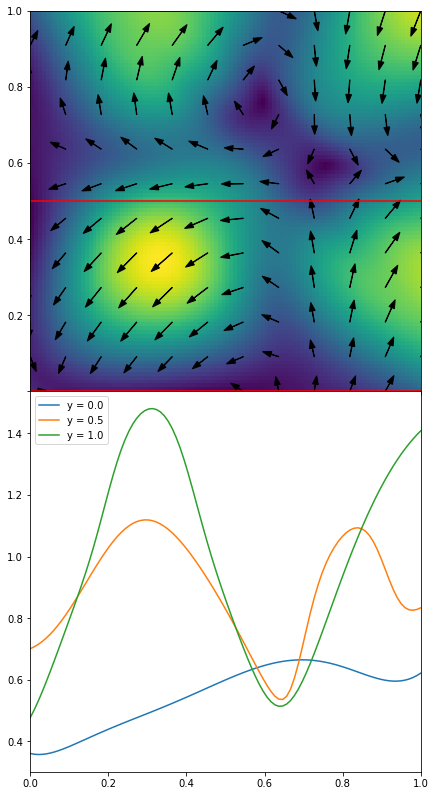

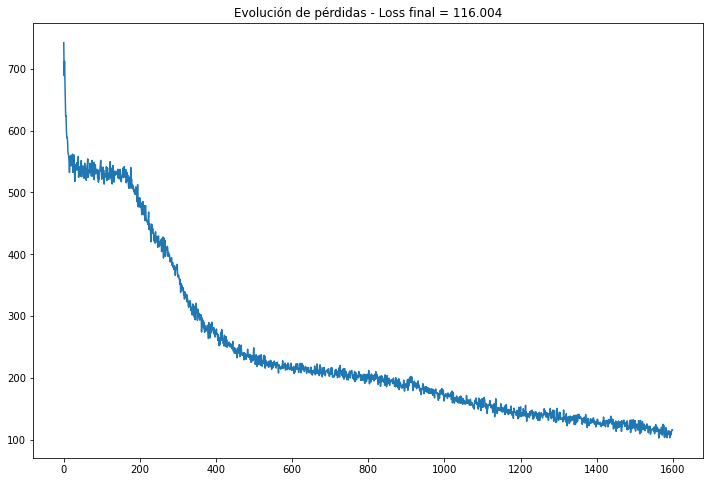

In [37]:
model = torch.nn.Sequential(torch.nn.Linear(N_in,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,N_out) )

model.load_state_dict(params_iniciales)

def f_pre(x):
    k1 = 13./(2*np.pi)
    k2 = 17./(2*np.pi)
    A1 = tensor([[k1,0.],[0.,k2],[3.,3.]])
    A2 = tensor([[0.,k1],[k2,0.],[3.,3.]])
    if len(x.size()) == 1:
        x1 = 2*A1@x
        x2 = 2*A2@x
        return -torch.sin(x1)*torch.sin(x2)
    elif len(x.size()) == 2: # Sólo funciona para vectores o vectores de vectores (matrices)
        x1 = (A@x.reshape(2,1)).reshape(2,1)
        x2 = (A@x.reshape(2,1)).reshape(2,1)
        return torch.sin(x1)*torch.sin(x2)

def error_pre(x):
    return torch.sum(torch.abs(model(x) - f_pre(x)))

def residuales_pre(X):
    res = 0
    i = 0
    for x in X:
        res += error_pre(x)
        i+=1
    return res#/i

N_dominio = 500
a = 0
b = 1

xy = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True) # N_dominio pares de números aleatorios entre a y b
# x1 = torch.FloatTensor(N_dominio,2).uniform_(N_dominio)
x = xy
z = model(xy)


optimizer = torch.optim.Adam(model.parameters(),lr=7e-4)

n_epochs = 1600
loss_list = []
t1 = DT.datetime.now()

plt.figure(figsize=(14,8))
for i in range(n_epochs):
    x = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True)
    optimizer.zero_grad()
    loss = residuales_pre(x)
    loss_list.append(loss.item()) # Cambié loss por loss.item(); el cambio incrementa en 1s el tiempo del ciclo, pero parece solucionar el problema de Ram. Tal vez hay alguna manera de liberar la memoria de loss
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)

# plt.savefig('its_f_transfer1.svg',bbox_inches='tight')
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs
print('Tiempo promedio:\t',avg)

params_pre1 = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas - Loss final = {:.3f}'.format(losses[-1]))
plt.plot(losses)

Tiempo promedio:	 4.0472365012500005


<Figure size 1728x576 with 0 Axes>

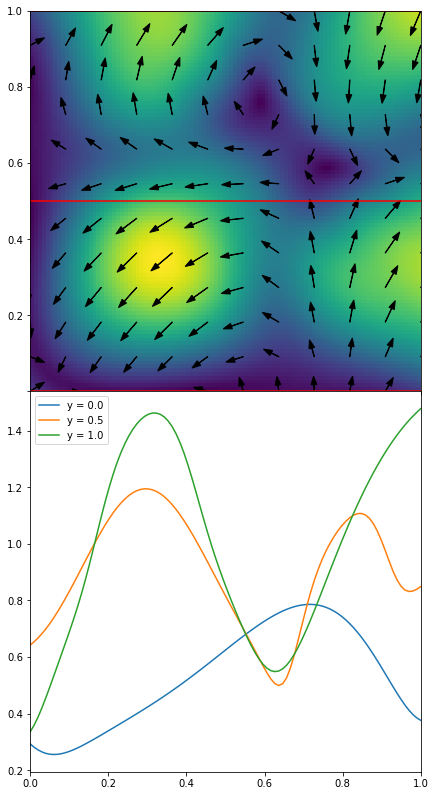

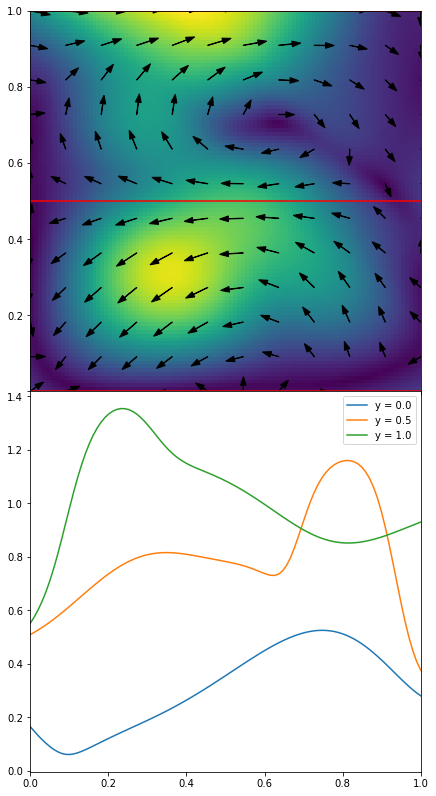

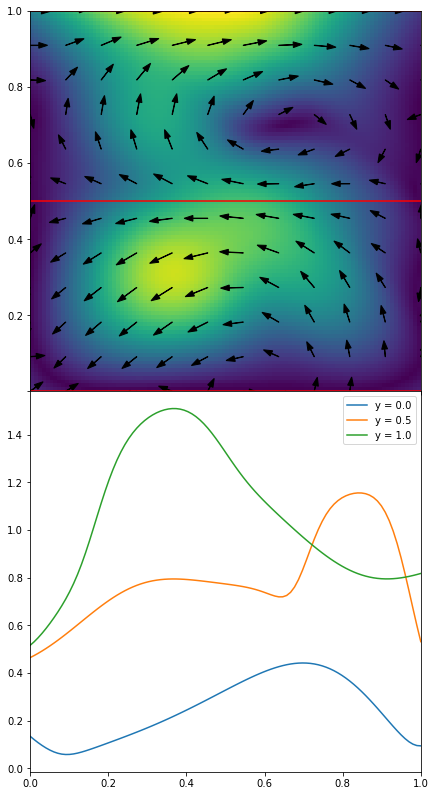

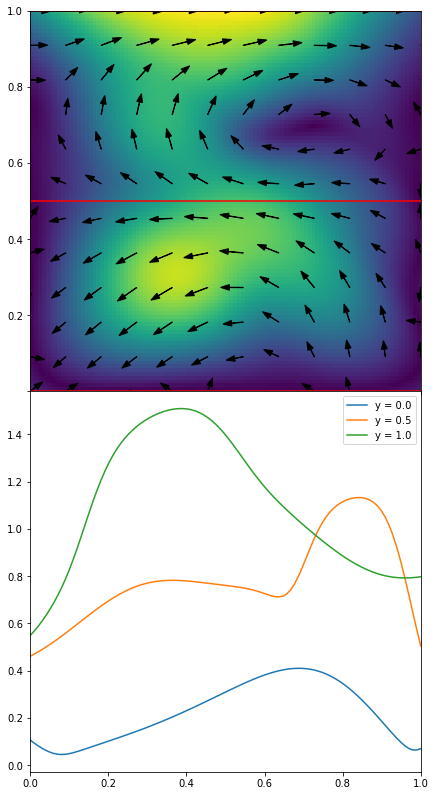

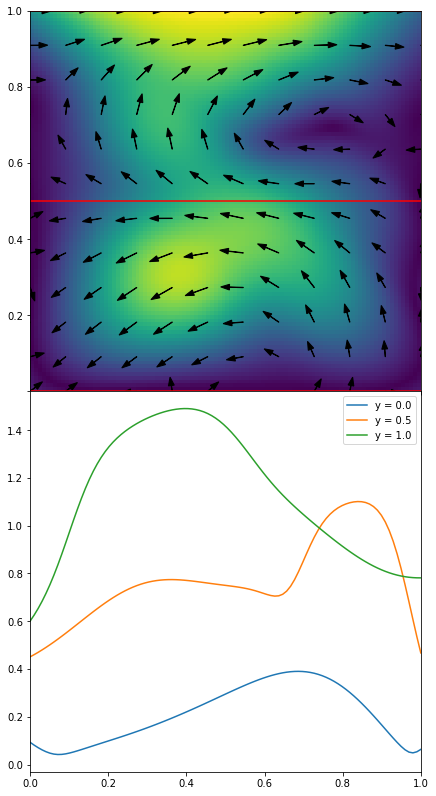

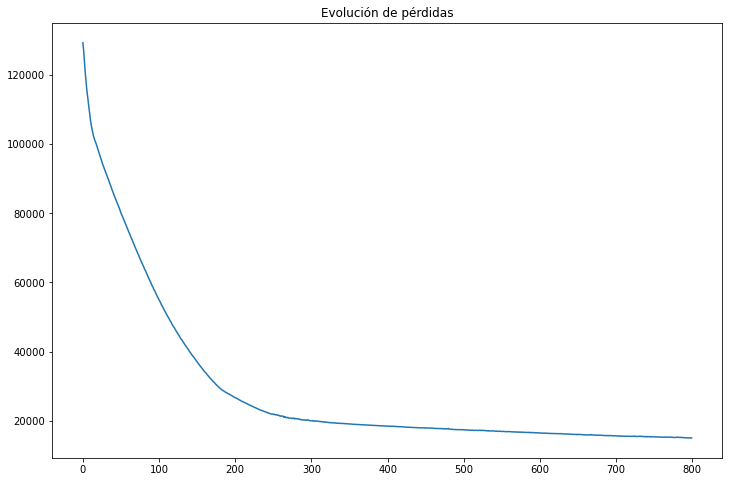

In [44]:
model = torch.nn.Sequential(torch.nn.Linear(N_in,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,50),
                            torch.nn.Tanh(),
                            torch.nn.Linear(50,N_out) )


model.load_state_dict(params_pre1)

# optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

alpha = 0.95
n_epochs = 800
loss_list = []
t1 = DT.datetime.now()

N_dominio = 100
N_complement = 400

dist = torch.distributions.beta.Beta(5,0.4)

def create_complement_sample(N_complement):
    sample_y = dist.sample((N_complement,))
    sample_y.requires_grad = True
    sample_x = torch.rand(N_complement,requires_grad = True)
    return torch.stack((sample_x,sample_y),dim=1)


plt.figure(figsize=(24,8))
for i in range(n_epochs):
    x1 = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True)
    x2 = create_complement_sample(N_complement)
    x = torch.vstack((x1,x2))
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss.item()) # Cambié loss por loss.item(); el cambio incrementa en 1s el tiempo del ciclo, pero parece solucionar el problema de Ram. Tal vez hay alguna manera de liberar la memoria de loss
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
        alpha += 0.01
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs

print('Tiempo promedio:\t',avg)

params_finales1 = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss#.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)

tensor(6023.0605, grad_fn=<AddBackward0>)

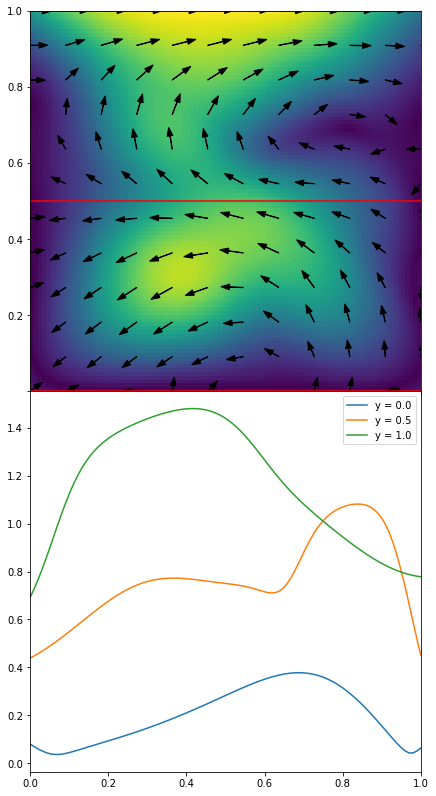

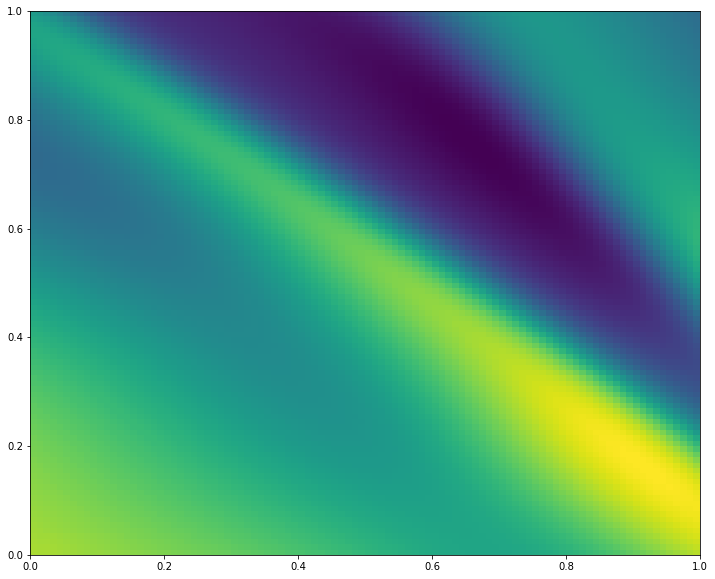

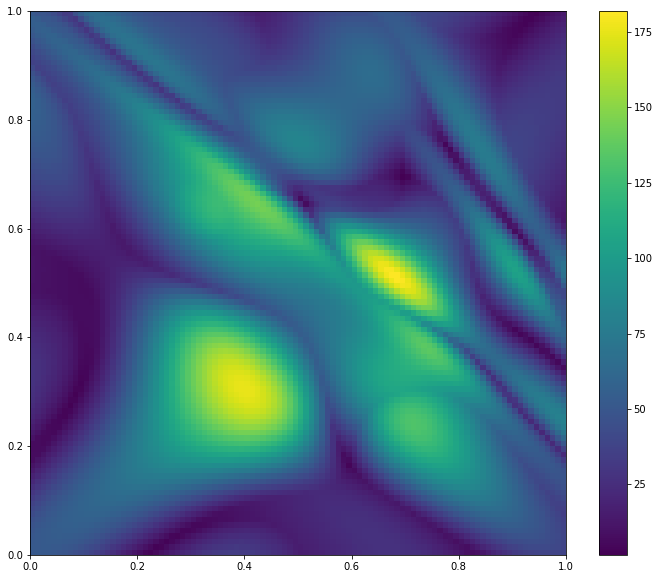

In [65]:
model.load_state_dict(params_finales1)
plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
def presion(x):
    return model(x)[2]


fig0,hm = plt.subplots(figsize=(12,10))
plot2D(presion,rango=((a,b),(a,b)),N_salidas=1,figsize=(7,7),axes=(hm,))
fig,heatmap = plt.subplots(figsize=(12,10))
plot2D_error(model,rango=((a,b),(a,b)),axes=(heatmap,))

residuales(x)

Tiempo promedio:	 1.96019384


<Figure size 1728x576 with 0 Axes>

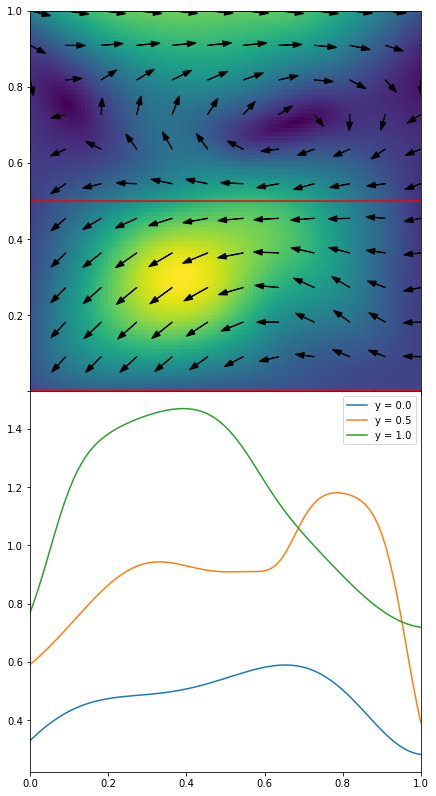

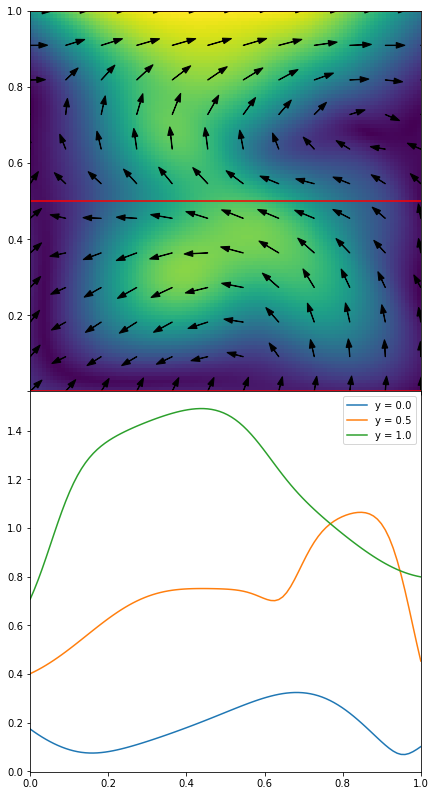

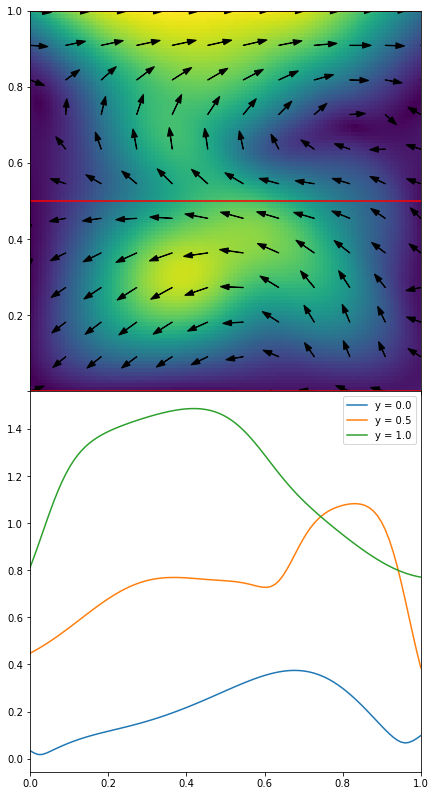

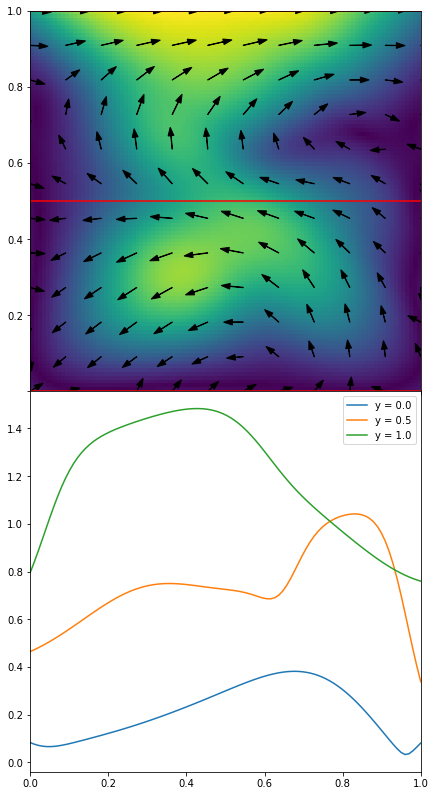

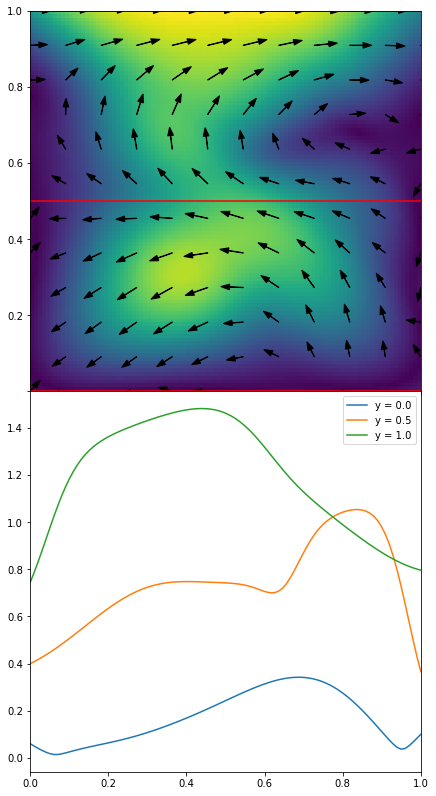

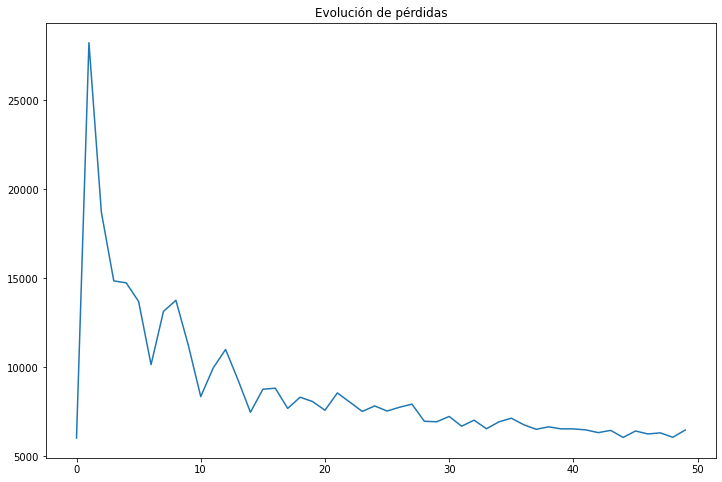

In [52]:
model.load_state_dict(params_finales1)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)



def error(x):
    v_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]])
    U = model(x)@v_splicer
    J = vel_jacobian(x,model)
    L = vel_laplacian(x,model)
    div_v = torch.sum(torch.diagonal(J))
    grad_p = pressure_gradient(x,model)
    
    HN = J@U.T + grad_p - 1/Re*L.T 
    e12 = torch.sum( torch.abs(HN) )
    e3 = torch.abs(div_v)
    return torch.abs( e12 + e3 )

def error_frontera():
    
    N_velocity = 100
    N_pressure = 20
    
    line = linspace(0,1,N=N_velocity)
    zeros = torch.zeros_like(line)
    ones = torch.ones_like(line)
    
    v_splicer = torch.tensor([[1.,0.],[0.,1.],[0.,0.]])
    p_splicer = torch.tensor([0.,0.,1.]).reshape(3,1)
    
    r_bottom,r_left,r_right,r_top = torch.hstack([line,zeros]),torch.hstack([zeros,line]),torch.hstack([ones,line]),torch.hstack([line,ones])
    r_corner = torch.tensor([0.,0.])
    
    e1 = torch.abs( model(r_bottom)@v_splicer - torch.tensor([0.,0.]) )
    e2 = torch.abs( model(r_left)@v_splicer - torch.tensor([0.,0.]) )
    e3 = torch.abs( model(r_right)@v_splicer - torch.tensor([0.,0.]) )
    e4 = torch.abs( model(r_top)@v_splicer - torch.tensor([1.,0.]) )
    e5 = N_pressure*torch.abs( model(r_corner)@p_splicer - torch.tensor(0.) )
    
    return torch.sum(e1+e2+e3+e4) + torch.sum(e5)


alpha = 0.6
def residuales(X):
#     print('Residuales')
    global alpha
    res = 0
    for x in X:
        x = x.reshape(1,2)
        res += error(x)*(1-alpha)
    res += error_frontera()*len(X)*alpha
    return res

alpha = 1.0
n_epochs = 50
loss_list = []
t1 = DT.datetime.now()

N_dominio = 100
N_complement = 100

dist = torch.distributions.beta.Beta(5,0.4)

def create_complement_sample(N_complement):
    sample_y = dist.sample((N_complement,))
    sample_y.requires_grad = True
    sample_x = torch.rand(N_complement,requires_grad = True)
    return torch.stack((sample_x,sample_y),dim=1)


plt.figure(figsize=(24,8))
for i in range(n_epochs):
    x1 = a + (b-a)*torch.rand(N_dominio,2,requires_grad=True)
    x2 = create_complement_sample(N_complement)
    x = torch.vstack((x1,x2))
    optimizer.zero_grad()
    loss = residuales(x)
    loss_list.append(loss.item()) # Cambié loss por loss.item(); el cambio incrementa en 1s el tiempo del ciclo, pero parece solucionar el problema de Ram. Tal vez hay alguna manera de liberar la memoria de loss
    loss.backward()
    optimizer.step()
    
    if i% int(n_epochs/5) == 0:
        plot2D(model,rango=((a,b),(a,b)),plot_cut=('y',cortes),N_salidas=2)
    
t2 = DT.datetime.now()
tiempo = (t2-t1).total_seconds()
avg = tiempo/n_epochs

print('Tiempo promedio:\t',avg)

params_finales3 = copy.deepcopy(model.state_dict())

losses = np.zeros(len(loss_list))
for i,loss in enumerate(loss_list):
    losses[i] = loss#.item()

plt.figure(figsize=(12,8))
plt.title('Evolución de pérdidas')
plt.plot(losses)